<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/auto_gluon/6_others_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [3]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 1
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

In [11]:
%%capture
!pip install autogluon

  Using cached autogluon-0.8.2-py3-none-any.whl (9.7 kB)
  Using cached autogluon.core-0.8.2-py3-none-any.whl (224 kB)
  Using cached autogluon.features-0.8.2-py3-none-any.whl (62 kB)
  Using cached autogluon.tabular-0.8.2-py3-none-any.whl (285 kB)
  Using cached autogluon.multimodal-0.8.2-py3-none-any.whl (372 kB)
  Using cached autogluon.timeseries-0.8.2-py3-none-any.whl (116 kB)
  Using cached boto3-1.28.73-py3-none-any.whl (135 kB)
  Using cached autogluon.common-0.8.2-py3-none-any.whl (61 kB)
  Using cached ray-2.3.1-cp310-cp310-manylinux2014_x86_64.whl (58.5 MB)
  Using cached grpcio-1.50.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached jsonschema-4.17.3-py3-none-any.whl (90 kB)
  Using cached seqeval-1.2.2-py3-none-any.whl
  Using cached evaluate-0.3.0-py3-none-any.whl (72 kB)
  Using cached accelerate-0.16.0-py3-none-any.whl (199 kB)
  Using cached timm-0.9.8-py3-none-any.whl (2.2 MB)
  Using cached torch-1.13.1-cp310-cp310-manylinux1_x86_64.

In [12]:
from autogluon.features.generators import AutoMLPipelineFeatureGenerator
from autogluon.tabular import FeatureMetadata
from autogluon.tabular import TabularDataset, TabularPredictor

# Download the data

In [34]:
os.listdir(manager.data_root_path)

['train.csv',
 'test.csv',
 'sample_submission.csv',
 'preproc_trial_1',
 'preproc_trial_2',
 'preproc_trial_3',
 'preproc_trial_4',
 'ParisHousing_additional_data.csv',
 'preproc_trial_joined_dataset']

In [35]:
train = pd.read_csv(f'{manager.data_root_path}/train.csv', index_col=0)
df_submission = pd.read_csv(f'{manager.data_root_path}/test.csv', index_col=0)
orig = pd.read_csv(f'{manager.data_root_path}/ParisHousing_additional_data.csv')

In [37]:
orig.shape, train.shape

((10000, 17), (22730, 17))

In [38]:
print(train.shape, df_submission.shape)
train.head()

(22730, 17) (15154, 16)


,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
id,,,,,,,,,,,,,,,,,
0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


# Clean outliers

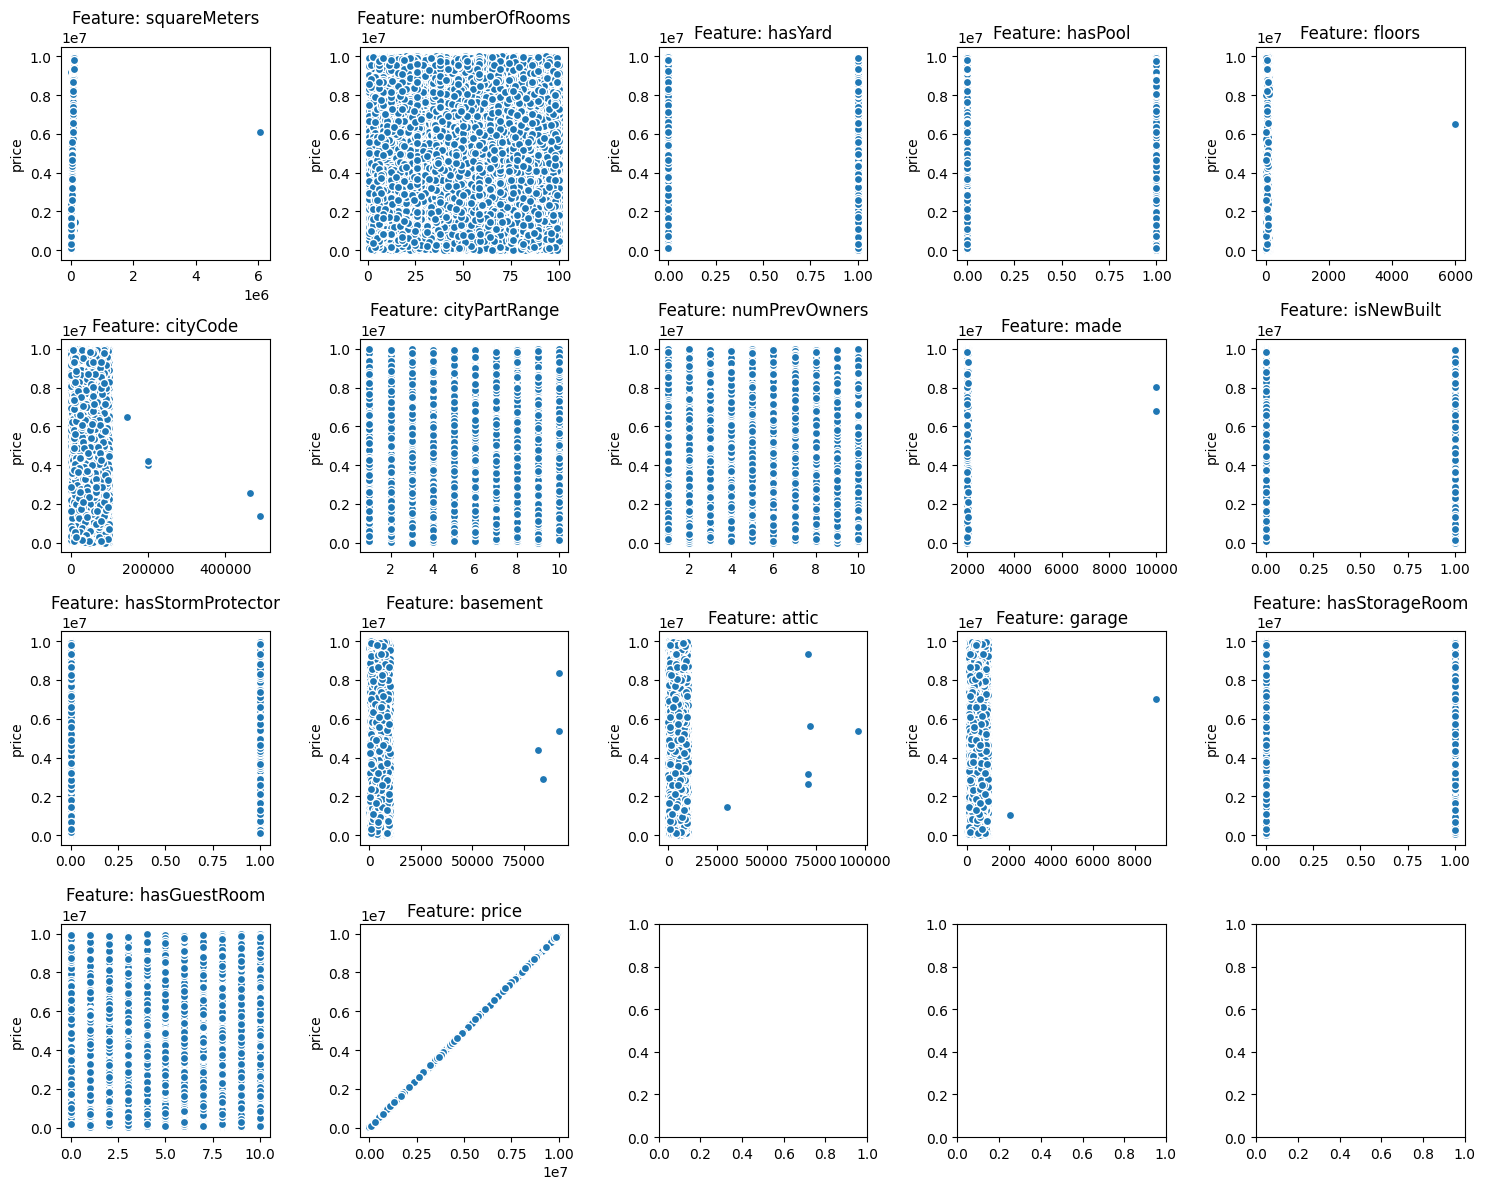

In [17]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    train,
    'price',
    train.columns
)

In [18]:
train.loc[(train['squareMeters'] > 1.25e5),'squareMeters'] = train.loc[(train['squareMeters'] > 1.25e5),'squareMeters']/100
train.drop(train[(train['squareMeters'] > 2e6)].index, inplace=True)
train.loc[(train['floors'] > 1e3),'floors'] = 60
train.drop(train[(train['floors'] > 1e3)].index, inplace=True)
train.loc[(train['made'] > 2.1e3),'made'] = 2000
train.drop(train[(train['basement'] > 3e4)].index, inplace=True)
train.drop(train[(train['attic'] > 2e4)].index, inplace=True)
train.drop(train[(train['garage'] > 2e3)].index, inplace=True)
train['price/sqm'] = train['price']/train['squareMeters']
train.loc[(train['price/sqm'] < 3),'price/sqm'] = train.loc[(train['price/sqm'] < 3),'price/sqm']*10

In [19]:
train.index

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            22720, 22721, 22722, 22723, 22724, 22725, 22726, 22727, 22728,
            22729],
           dtype='int64', name='id', length=22717)

In [20]:
train.reset_index(drop=True, inplace=True)

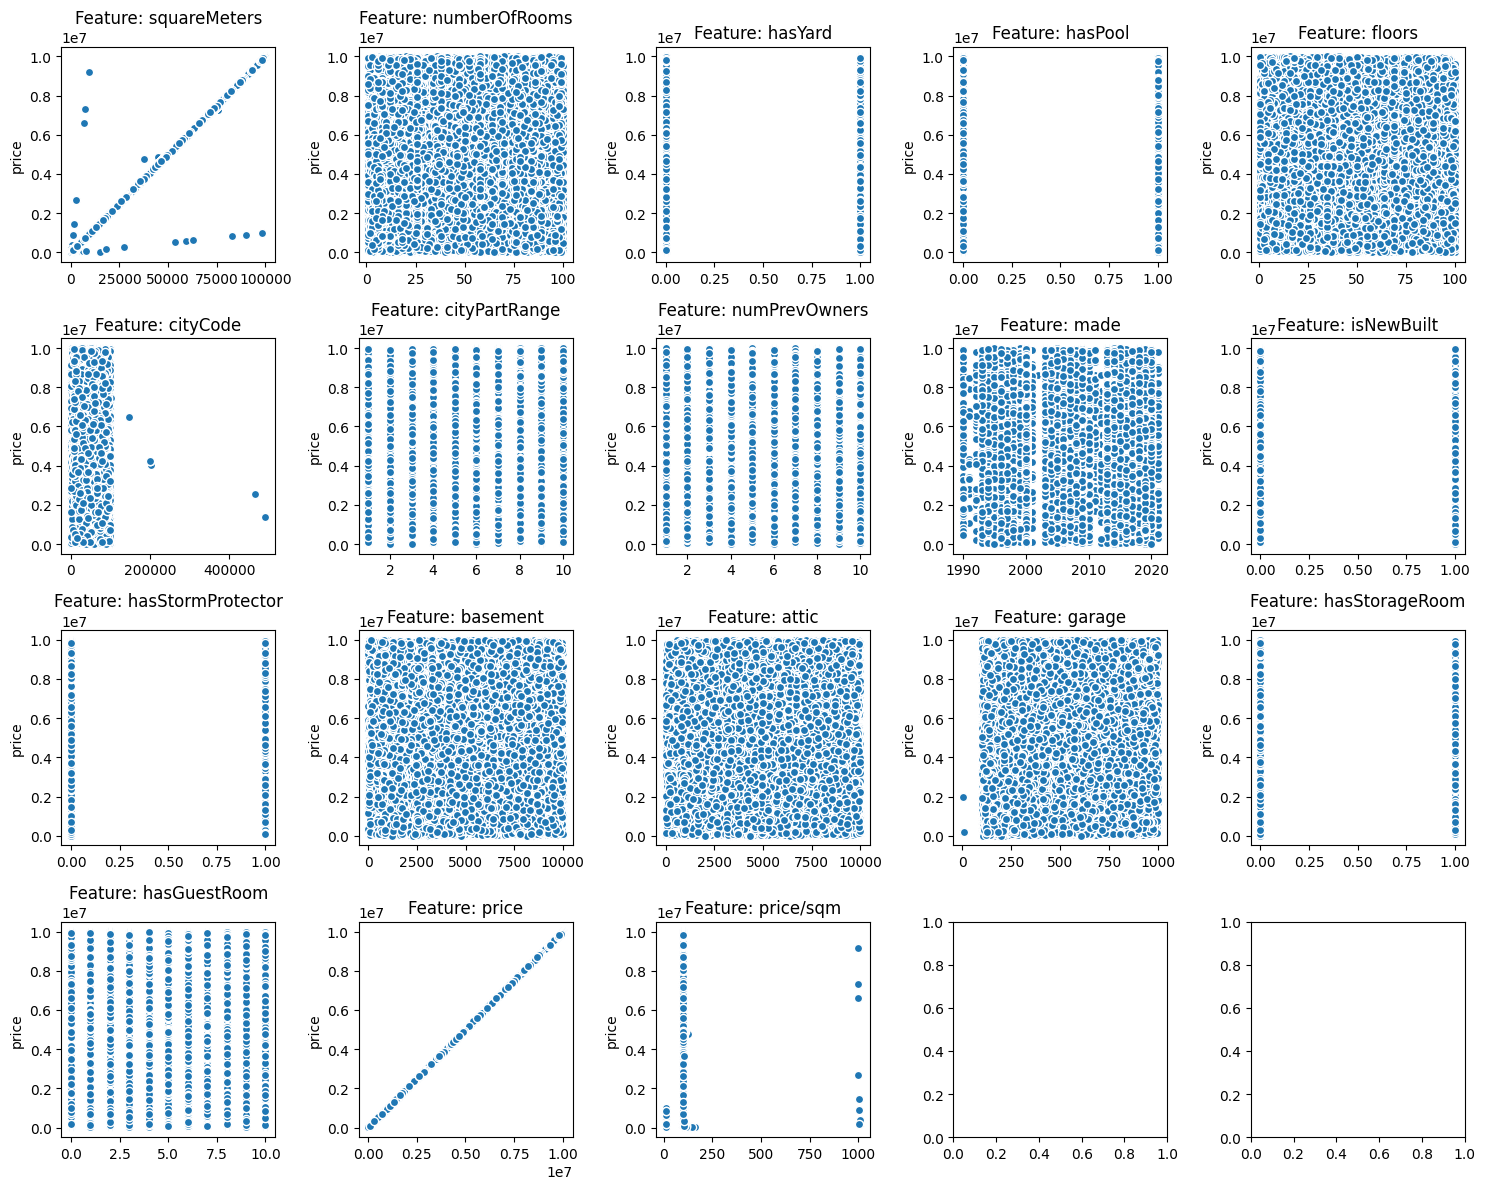

In [26]:
visualize_target_vs_columns(
    train,
    'price',
    train.columns
)

In [41]:
train['classes'] = 0
train.loc[(train['price']/train['squareMeters'] >175),'classes'] = 2
train.loc[(train['price']/train['squareMeters'] <40),'classes'] = 1
train['price/sqm'] = train['price']/train['squareMeters']
train.drop(index=21479,inplace=True)
train.reset_index(drop=True,inplace=True)

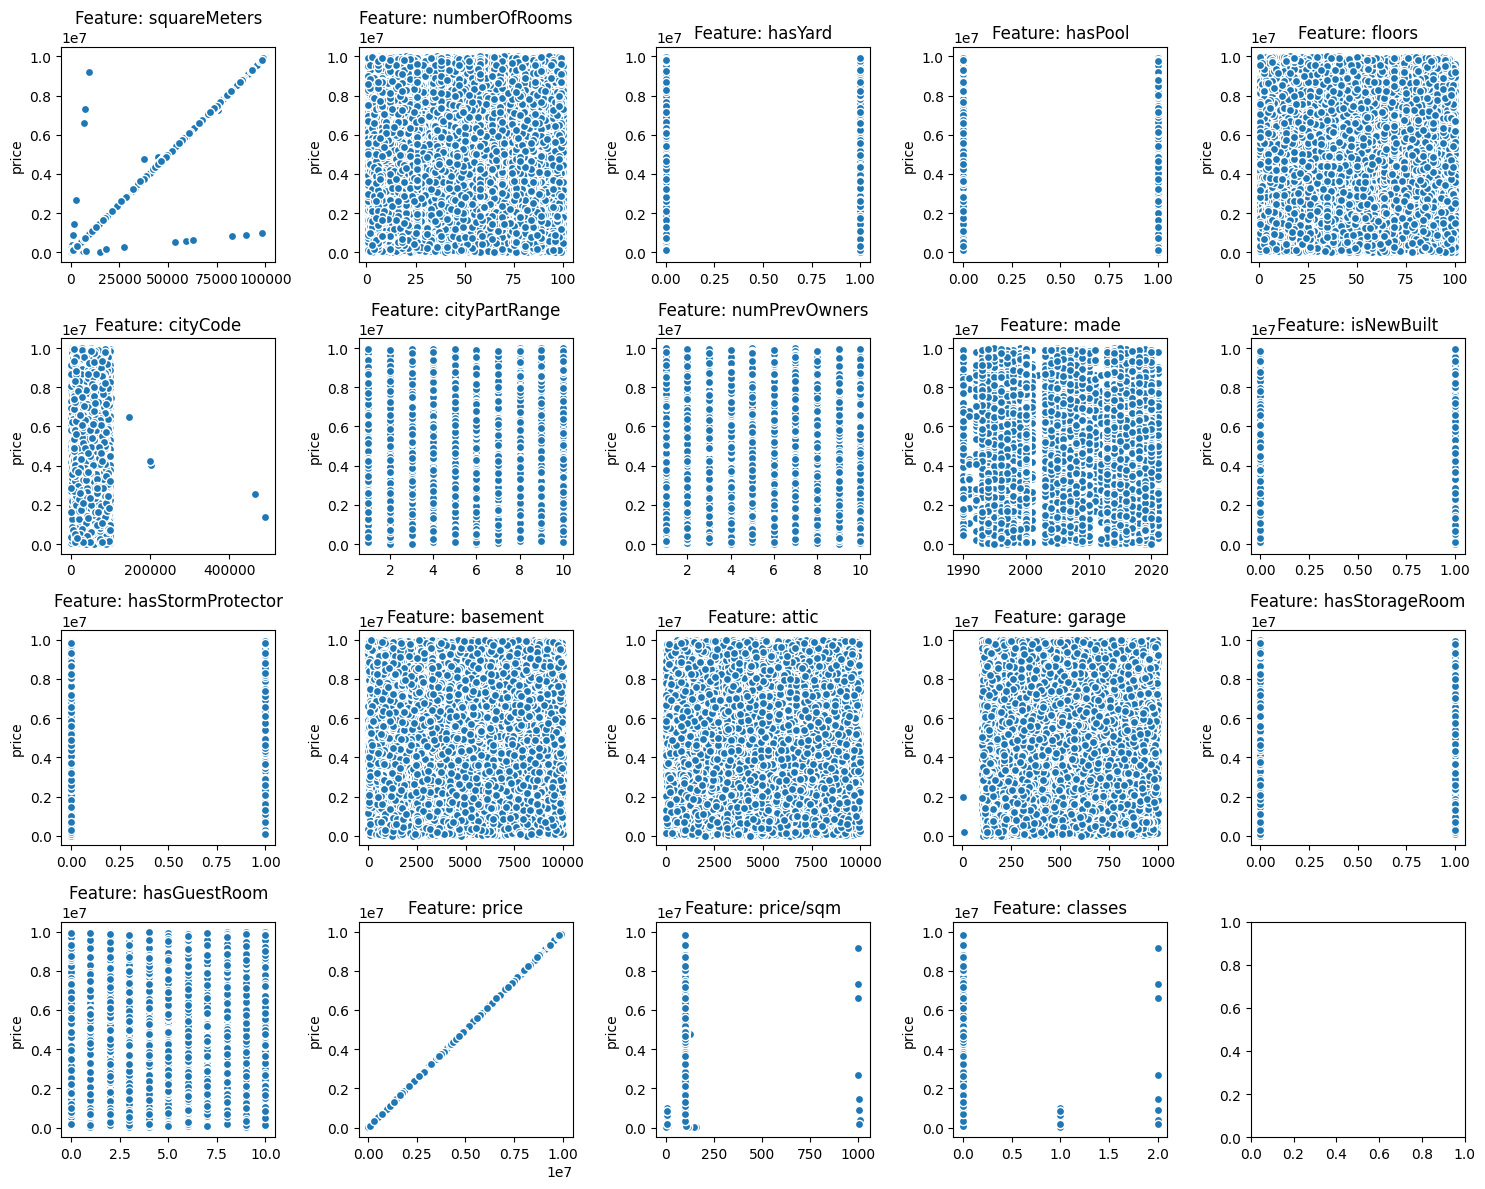

In [28]:
visualize_target_vs_columns(
    train,
    'price',
    train.columns
)

In [39]:
train['age'] = 2021 - train['made']
orig['age'] = 2021 - orig['made']

In [29]:
FEATURES = ['squareMeters','basement','garage','age','cityCode','price']

# Train model

In [42]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

os.system('mkdir autogluon_models')
FOLDS = 5
skf = StratifiedKFold(n_splits=FOLDS,shuffle=True,random_state=42)
oof = np.zeros(len(train))
for fold, (train_idx, valid_idx) in \
    enumerate(skf.split(train, train['classes'])):

    print(f'FOLD {fold}')

    X_train = train.loc[train_idx, FEATURES]
    X_train = X_train.append(orig[FEATURES])
    X_valid = train.loc[valid_idx, FEATURES]

    predictor = TabularPredictor(
        label='price',
        problem_type='regression',
        eval_metric='rmse',
        path=f'./autogluon_models/fold{fold}'
    )

    predictor.fit(
        num_gpus=1,
        train_data=X_train,
        tuning_data=X_valid,
        time_limit=10*60,  # wall clock time in seconds
        auto_stack=False,  # Change it, use 'good-quality'
        _save_bag_folds=False,
        # presets = ['good_quality', 'optimize_for_deployment']
        hyperparameters='light',  # ['default', ]
        keep_only_best= True
    )
    predictor.leaderboard(X_valid)

    model = TabularPredictor.load(f'./autogluon_models/fold{fold}/')
    oof_preds = model.predict(X_valid)
    oof[valid_idx] = oof_preds

rmse = mean_squared_error(train['price'].values, oof, squared=False)
print('price rmse =',rmse,'\n')
train['autogluon_price_oof'] = oof

<ipython-input-42-a0b17905faee>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(orig[FEATURES])
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "./autogluon_models/fold0/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.82 GB / 115.66 GB (69.0%)
Train Data Rows:    28183
Train Data Columns: 5
Tuning Data Rows:    4546
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11525.38 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

FOLD 0


	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	Types of features in processed data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	0.1s = Fit runtime
	5 features in original data used to generate 5 features in processed data.
	Train Data (Processed) Memory Usage: 1.31 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.17s ...
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'XGB': {},
	'FAST

[1000]	valid_set's rmse: 234930
[2000]	valid_set's rmse: 230957
[3000]	valid_set's rmse: 228872
[4000]	valid_set's rmse: 227852
[5000]	valid_set's rmse: 227246
[6000]	valid_set's rmse: 226932
[7000]	valid_set's rmse: 226796
[8000]	valid_set's rmse: 226494
[9000]	valid_set's rmse: 226383
[10000]	valid_set's rmse: 226269


	-226263.9807	 = Validation score   (-root_mean_squared_error)
	31.55s	 = Training   runtime
	12.29s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 14352.56s of the 14352.55s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-218496.92	 = Validation score   (-root_mean_squared_error)
	1.55s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 14350.79s of the 14350.78s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-205429.7285	 = Validation score   (-root_mean_squared_error)
	32.49s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 14315.58s of the 14315.58s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-212053.5503	 = Validation score   (-root_mean_squared_error)
	15.83s	 = Training   runtime
	0.01s	 = Validat

                 model     score_test      score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -205284.800309 -205284.800309        1.725087       0.488703  78.480869                 0.006742                0.000735           0.387142            2       True          5
1      RandomForestMSE -205429.728502 -205429.728502        1.441310       0.362662  32.486883                 1.441310                0.362662          32.486883            1       True          1
2             CatBoost -212053.550278 -212053.550278        0.025359       0.009381  15.827979                 0.025359                0.009381          15.827979            1       True          2
3        LightGBMLarge -217358.701117 -217358.701117        0.142605       0.086368   2.078737                 0.142605                0.086368           2.078737            1       True          4
4       Ne

<ipython-input-42-a0b17905faee>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(orig[FEATURES])
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "./autogluon_models/fold1/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.46 GB / 115.66 GB (68.7%)
Train Data Rows:    28183
Train Data Columns: 5
Tuning Data Rows:    4546
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11322.15 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

FOLD 1


	Stage 4 Generators:
		Fitting DropUniqueFeatureGenerator...
	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	Types of features in processed data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	0.2s = Fit runtime
	5 features in original data used to generate 5 features in processed data.
	Train Data (Processed) Memory Usage: 1.31 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.24s ...
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
User-specified model hyperparameters to be fit:
{
	'NN

[1000]	valid_set's rmse: 85293.2


	-84665.3225	 = Validation score   (-root_mean_squared_error)
	5.15s	 = Training   runtime
	0.81s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 14393.41s of the 14393.41s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-79363.948	 = Validation score   (-root_mean_squared_error)
	1.18s	 = Training   runtime
	0.04s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 14392.16s of the 14392.16s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-70522.7765	 = Validation score   (-root_mean_squared_error)
	37.54s	 = Training   runtime
	0.37s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 14353.03s of the 14353.03s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-64756.2263	 = Validation score   (-root_mean_squared_error)
	2.25s	 = Training   runtime
	0.0s	 = Validation run

                 model    score_test     score_val  pred_time_test  pred_time_val    fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -56526.863137 -56526.863137        3.500075       1.944532  126.707946                 0.006979                0.001202           0.648305            2       True          8
1      NeuralNetFastAI -62241.820206 -62241.820206        0.094491       0.114075   43.821639                 0.094491                0.114075          43.821639            1       True          5
2             CatBoost -64756.226266 -64756.226266        0.057726       0.003990    2.245417                 0.057726                0.003990           2.245417            1       True          3
3      RandomForestMSE -70522.776495 -70522.776495        1.843542       0.370993   37.541476                 1.843542                0.370993          37.541476            1       True          2
4        ExtraT

<ipython-input-42-a0b17905faee>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(orig[FEATURES])
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "./autogluon_models/fold2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   78.94 GB / 115.66 GB (68.3%)
Train Data Rows:    28183
Train Data Columns: 5
Tuning Data Rows:    4546
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11227.64 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

FOLD 2


Fitting model: LightGBMXT ... Training model for up to 14399.85s of the 14399.84s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead


[1000]	valid_set's rmse: 234922
[2000]	valid_set's rmse: 229965
[3000]	valid_set's rmse: 226848
[4000]	valid_set's rmse: 224468
[5000]	valid_set's rmse: 222620
[6000]	valid_set's rmse: 221291
[7000]	valid_set's rmse: 220276
[8000]	valid_set's rmse: 219627
[9000]	valid_set's rmse: 218520
[10000]	valid_set's rmse: 217549


	-217505.165	 = Validation score   (-root_mean_squared_error)
	25.8s	 = Training   runtime
	11.68s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 14359.03s of the 14359.02s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead


[1000]	valid_set's rmse: 193948
[2000]	valid_set's rmse: 192436
[3000]	valid_set's rmse: 192175
[4000]	valid_set's rmse: 192155


	-191913.165	 = Validation score   (-root_mean_squared_error)
	8.44s	 = Training   runtime
	1.7s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 14348.31s of the 14348.3s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-188487.7919	 = Validation score   (-root_mean_squared_error)
	36.47s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 14309.05s of the 14309.04s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-188515.5194	 = Validation score   (-root_mean_squared_error)
	4.06s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ... Training model for up to 14304.97s of the 14304.97s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-208885.8968	 = Validation score   (-root_mean_squared_error)
	5.1s	 = Training   runtime
	0.29s	 = Validatio

                 model     score_test      score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -182938.290742 -182938.290742        4.071689       2.502826  52.512396                 0.010612                0.000868           0.591907            2       True          6
1      RandomForestMSE -188487.791899 -188487.791899        1.544344       0.700686  36.471097                 1.544344                0.700686          36.471097            1       True          2
2             CatBoost -188515.519439 -188515.519439        0.063250       0.004369   4.055145                 0.063250                0.004369           4.055145            1       True          3
3              XGBoost -190500.185679 -190500.185679        0.063594       0.036000   1.048084                 0.063594                0.036000           1.048084            1       True          4
4         

<ipython-input-42-a0b17905faee>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(orig[FEATURES])
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "./autogluon_models/fold3/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   78.57 GB / 115.66 GB (67.9%)
Train Data Rows:    28183
Train Data Columns: 5
Tuning Data Rows:    4546
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11190.89 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

FOLD 3


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	Types of features in processed data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	0.2s = Fit runtime
	5 features in original data used to generate 5 features in processed data.
	Train Data (Processed) Memory Usage: 1.31 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.22s ...
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name

[1000]	valid_set's rmse: 172158
[2000]	valid_set's rmse: 168181
[3000]	valid_set's rmse: 167241
[4000]	valid_set's rmse: 166534
[5000]	valid_set's rmse: 165716
[6000]	valid_set's rmse: 165460
[7000]	valid_set's rmse: 165458
[8000]	valid_set's rmse: 165350
[9000]	valid_set's rmse: 165433
[10000]	valid_set's rmse: 165461


	-165217.2347	 = Validation score   (-root_mean_squared_error)
	26.33s	 = Training   runtime
	6.47s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 14365.54s of the 14365.53s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-131713.9127	 = Validation score   (-root_mean_squared_error)
	1.27s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 14364.13s of the 14364.12s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-105590.3033	 = Validation score   (-root_mean_squared_error)
	37.05s	 = Training   runtime
	0.72s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 14324.62s of the 14324.61s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-139449.3342	 = Validation score   (-root_mean_squared_error)
	4.7s	 = Training   runtime
	0.01s	 = Validatio

                 model     score_test      score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      RandomForestMSE -105590.303292 -105590.303292        1.681419       0.720856  37.046812                 1.681419                0.720856          37.046812            1       True          1
1  WeightedEnsemble_L2 -105590.303292 -105590.303292        1.768470       0.721738  37.506424                 0.087050                0.000882           0.459612            2       True          2


<ipython-input-42-a0b17905faee>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(orig[FEATURES])
Beginning AutoGluon training ... Time limit = 14400s
AutoGluon will save models to "./autogluon_models/fold4/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   78.22 GB / 115.66 GB (67.6%)
Train Data Rows:    28184
Train Data Columns: 5
Tuning Data Rows:    4545
Tuning Data Columns: 5
Label Column: price
Preprocessing data ...
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11190.79 MB
	Train Data (Original)  Memory Usage: 1.31 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify spe

FOLD 4


	Stage 5 Generators:
		Fitting DropDuplicatesFeatureGenerator...
	Types of features in original data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	Types of features in processed data (raw dtype, special dtypes):
		('int', []) : 5 | ['squareMeters', 'basement', 'garage', 'age', 'cityCode']
	0.2s = Fit runtime
	5 features in original data used to generate 5 features in processed data.
	Train Data (Processed) Memory Usage: 1.31 MB (0.0% of available memory)
Data preprocessing and feature engineering runtime = 0.21s ...
AutoGluon will gauge predictive performance using evaluation metric: 'root_mean_squared_error'
	This metric's sign has been flipped to adhere to being higher_is_better. The metric score can be multiplied by -1 to get the metric value.
	To change this, specify the eval_metric parameter of Predictor()
User-specified model hyperparameters to be fit:
{
	'NN_TORCH': {},
	'GBM': [{'extra_trees': True, 'ag_args': {'name

[1000]	valid_set's rmse: 222881
[2000]	valid_set's rmse: 215375
[3000]	valid_set's rmse: 211200
[4000]	valid_set's rmse: 209059
[5000]	valid_set's rmse: 207242
[6000]	valid_set's rmse: 205688
[7000]	valid_set's rmse: 205066
[8000]	valid_set's rmse: 204476
[9000]	valid_set's rmse: 203901
[10000]	valid_set's rmse: 203333


	-203318.3883	 = Validation score   (-root_mean_squared_error)
	33.5s	 = Training   runtime
	9.4s	 = Validation runtime
Fitting model: LightGBM ... Training model for up to 14354.67s of the 14354.66s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-184224.761	 = Validation score   (-root_mean_squared_error)
	1.96s	 = Training   runtime
	0.13s	 = Validation runtime
Fitting model: RandomForestMSE ... Training model for up to 14352.49s of the 14352.48s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-154363.1074	 = Validation score   (-root_mean_squared_error)
	37.77s	 = Training   runtime
	0.38s	 = Validation runtime
Fitting model: CatBoost ... Training model for up to 14313.11s of the 14313.11s of remaining time.
Specified total num_gpus: 1, but only 0 are available. Will use 0 instead
	-170713.0701	 = Validation score   (-root_mean_squared_error)
	3.99s	 = Training   runtime
	0.0s	 = Validation 

                 model     score_test      score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0  WeightedEnsemble_L2 -154047.101765 -154047.101765        1.696956       0.547090  43.701791                 0.006104                0.001262           0.701522            2       True          4
1      RandomForestMSE -154363.107369 -154363.107369        1.375412       0.375463  37.774974                 1.375412                0.375463          37.774974            1       True          1
2              XGBoost -161269.802337 -161269.802337        0.163167       0.067237   2.038820                 0.163167                0.067237           2.038820            1       True          2
3        LightGBMLarge -161729.657352 -161729.657352        0.152274       0.103128   3.186475                 0.152274                0.103128           3.186475            1       True          3
price rmse